In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

### Load Annotated Data

In [2]:
d_b, d_r = load_cf_data()

time: 17.4 s


In [3]:
l_b = average(d_b['aggression_score'].dropna())
l_r = average(d_r['aggression_score'].dropna())

time: 76.7 ms


In [4]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

time: 628 ms


### Split into train/dev and test

In [5]:
b_train, b_test = train_test_split(data_b, test_size = 0.2, random_state=0)
r_train, r_test = train_test_split(data_r, test_size = 0.2, random_state=0)
br_train = pd.concat([b_train, r_train])
br_test = pd.concat([b_test, r_test])

time: 44.8 ms


In [6]:
len(b_test.merge(b_train, left_index = True, right_index = True, how = 'inner'))

0

time: 7.88 ms


In [7]:
len(r_test.merge(r_train, left_index = True, right_index = True, how = 'inner'))

0

time: 4.43 ms


In [8]:
len(br_test.merge(br_train, left_index = True, right_index = True, how = 'inner'))

13

time: 37.9 ms


### NGram Regression Pipeline

In [26]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge()),
])

param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.01, 0.1, 0.5, 1),
}

time: 9.19 ms


### Hyper-Parameter tuning

In [27]:
tune (b_train['x'], b_train['y'], cv_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)


Best parameters set found:
{'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'clf__alpha': 1, 'vect__max_features': None} -0.19703850052


Grid scores:
-0.22680 (+/-0.00209) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'clf__alpha': 0.01, 'vect__max_features': None}
-0.25056 (+/-0.00227) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'clf__alpha': 0.01, 'vect__max_features': None}
-0.23603 (+/-0.00070) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'clf__alpha': 0.01, 'vect__max_features': 5000}
-0.23397 (+/-0.00129) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'clf__alpha': 0.01, 'vect__max_features': 5000}
-0.24845 (+/-0.00228) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'clf__alpha': 0.01, 'vect__max_features': 10000}
-0.25068 (+/-0.00129) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'clf__alpha': 0.01, 'vect__max_features': 10000}
-0.36411 (+/-0.00309) for {'vect__analyzer': 'char', 'vect_

In [34]:
## Be very careful to transcribe the correct params
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge(alpha = 1.0)),
])

time: 48.3 ms


### Train on blocked

In [11]:
b_model = optimal_pipeline.fit(b_train['x'], b_train['y'])

time: 2min 52s


Eval on blocked

Explained Variance: 0.707
R^2: 0.707
Mean squared error: 0.199
Mean absolute error: 0.334
Median absolute error: 0.256
Pearson: 0.841
Spearman: 0.758


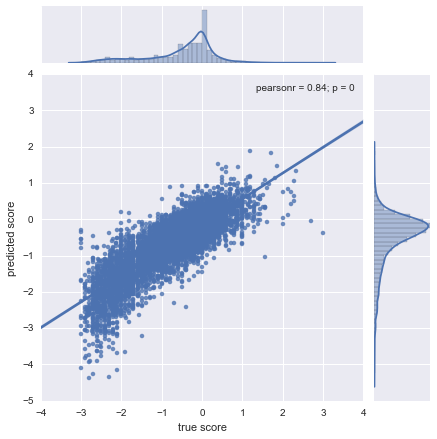

time: 35.4 s


In [12]:
print('Eval on blocked\n')
_= eval_regression(b_model, b_test, plot = True)

Eval on random

Explained Variance: 0.422
R^2: 0.252
Mean squared error: 0.127
Mean absolute error: 0.271
Median absolute error: 0.218
Pearson: 0.672
Spearman: 0.555


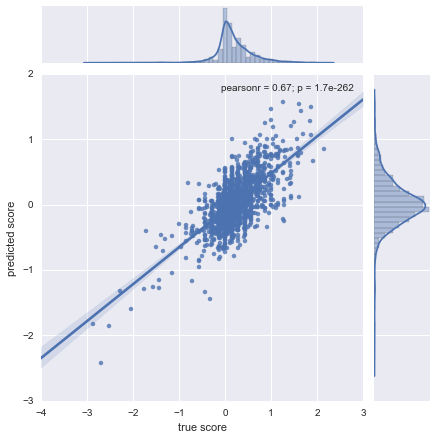

time: 8.18 s


In [13]:
print('Eval on random\n')
_= eval_regression(b_model, r_test, plot = True)

### Train on random

In [14]:
r_model = optimal_pipeline.fit(r_train['x'], r_train['y'])

time: 34.1 s


Eval on blocked

Explained Variance: 0.450
R^2: 0.163
Mean squared error: 0.570
Mean absolute error: 0.527
Median absolute error: 0.325
Pearson: 0.717
Spearman: 0.628


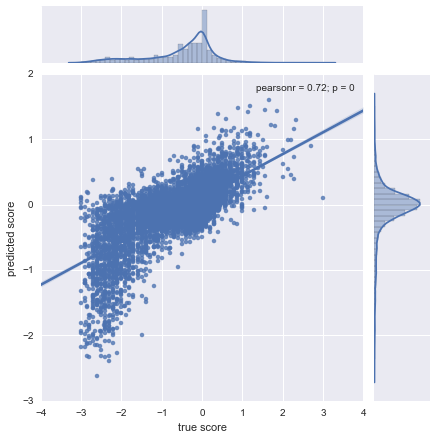

time: 27.5 s


In [15]:
print('Eval on blocked\n')
_= eval_regression(r_model, b_test, plot = True)

Eval on random

Explained Variance: 0.506
R^2: 0.505
Mean squared error: 0.084
Mean absolute error: 0.199
Median absolute error: 0.141
Pearson: 0.712
Spearman: 0.659


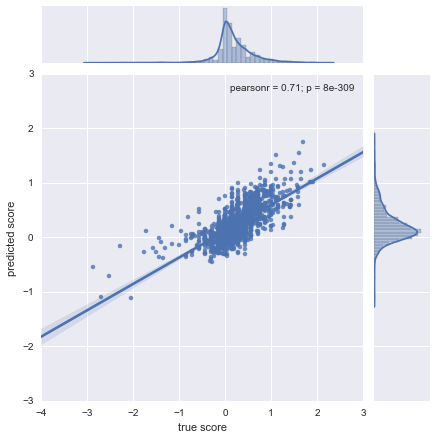

time: 6.31 s


In [16]:
print('Eval on random\n')
_= eval_regression(r_model, r_test, plot =  True)

### Train on both

In [17]:
br_model = optimal_pipeline.fit(br_train['x'], br_train['y'])

time: 3min 34s


Eval on blocked

Explained Variance: 0.711
R^2: 0.711
Mean squared error: 0.197
Mean absolute error: 0.330
Median absolute error: 0.253
Pearson: 0.844
Spearman: 0.764


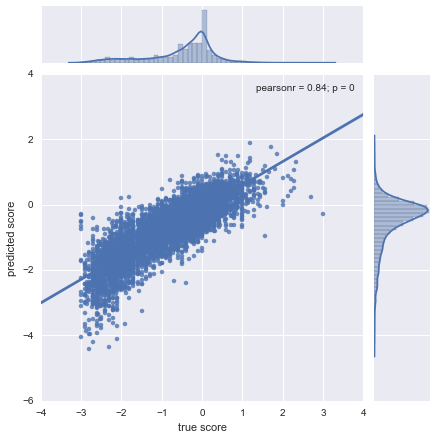

time: 29.6 s


In [18]:
print('Eval on blocked\n')
_= eval_regression(br_model, b_test, plot = True)

Eval on random

Explained Variance: 0.463
R^2: 0.408
Mean squared error: 0.101
Mean absolute error: 0.239
Median absolute error: 0.188
Pearson: 0.702
Spearman: 0.601


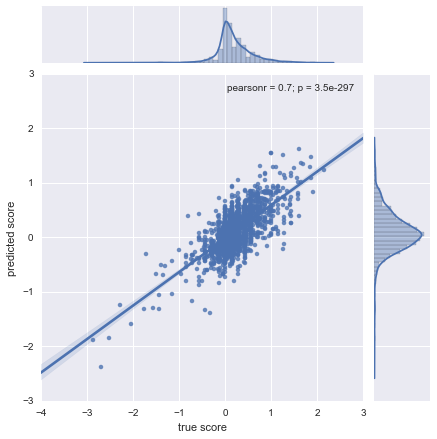

time: 6.31 s


In [19]:
print('Eval on random\n')
_= eval_regression(br_model, r_test, plot = True)

Eval on both

Explained Variance: 0.727
R^2: 0.727
Mean squared error: 0.182
Mean absolute error: 0.316
Median absolute error: 0.239
Pearson: 0.852
Spearman: 0.773


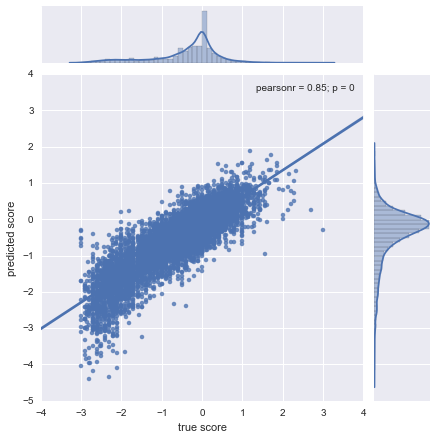

time: 31.5 s


In [20]:
print('Eval on both\n')
_= eval_regression(br_model, br_test, plot = True)

### Error Analysis

In [21]:
d_redisdual = get_reg_residuals(br_model, br_test)
print_reg_errors(d_redisdual, n=10)

COMMENT:
 PASTE FERICIT! Buna din nou! As vrea macar sa-mi trimiti un semn sa stiu daca ai primit cumva mesajele mele.  http://www.bebo.com/CarolinaW8 carowesselly@yahoo.com Iti doresc sa ai un Paste Fericit alaturi de cei dragi tie !
SCORES: Actual: 3.00, Predicted: -0.29, Residual: 3.29


COMMENT:
 Email Nazdar, poslal som ti mail tak si cekni emailovu schranku. Dakujem   
SCORES: Actual: -3.00, Predicted: -0.30, Residual: -2.70


COMMENT:
thumb|left|Kobieta wypija spermę ze szklankiA i jeszcze jedno jak ci się nudzi i jesteś spragniony wrażeń napij się spermy.
SCORES: Actual: -3.00, Predicted: -0.32, Residual: -2.68


COMMENT:
Aw. Little InaMaka got tired of playing. Wikipedia is so boring without you. Hugs and kisses. Your BFF,   
SCORES: Actual: 1.57, Predicted: -0.96, Residual: 2.53


COMMENT:
 Biležka, Tuđinština...Pizda Materina - Ma delajte kaj 'očete, boli me kurac! Se zbrišite i hojte v Pizdu Materinu!
SCORES: Actual: -3.00, Predicted: -0.51, Residual: -2.49


COMMENT:
Thank

### Learning Curves!
Split blocked data into train and test. Train on a portion of train and test on test. This shows how well we do on blocked data as we add more training data.

In [37]:
def get_pearson(model, test):
    return pearsonr(test['y'], model.predict(test['x']))[0]

time: 4.9 ms


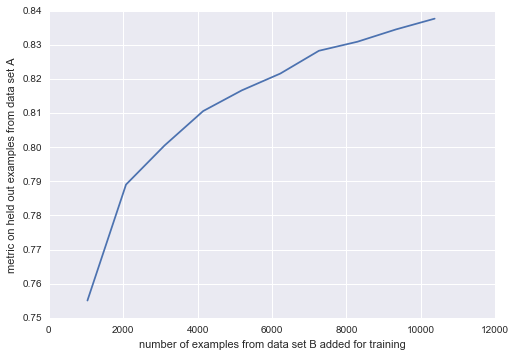

time: 5min 11s


In [24]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, b_test, b_train, get_pearson, test_size = 0.5)
plot_adding_other_data(ms, metrics)

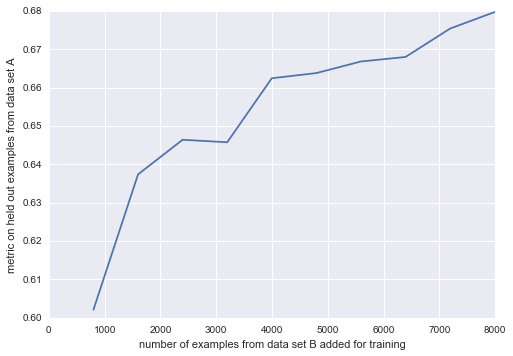

time: 1min 45s


In [41]:
ms, metrics = eval_adding_other_data(optimal_pipeline, None, r_test, r_train, get_pearson, test_size = 0.5)
plot_adding_other_data(ms, metrics)

### How does adding blocked data change performance on random data?

Incrementally add blocked data to full random data set on training. Eval on held out blocked data.

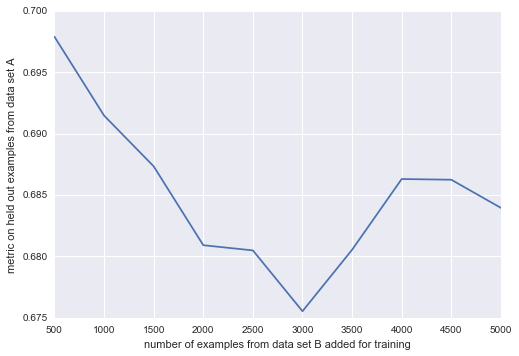

time: 3min 17s


In [39]:
ms, metrics = eval_adding_other_data(optimal_pipeline, r_train, r_test, b_train[:5000], get_pearson, test_size = 0.8)
plot_adding_other_data(ms, metrics)

### How does adding random data change performance on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

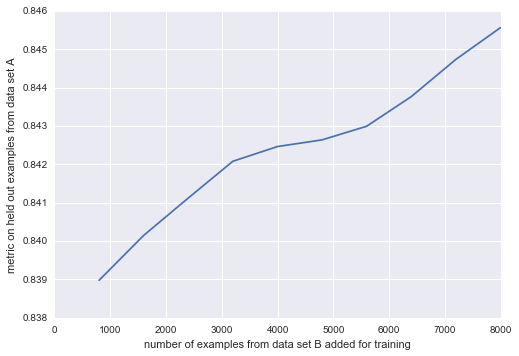

time: 23min 3s


In [26]:
ms, metrics = eval_adding_other_data(optimal_pipeline, b_train, b_test, r_train, get_pearson, test_size = 0.8)
plot_adding_other_data(ms, metrics)

# Final Model

In [40]:
br_data = pd.concat([data_r,data_b[:500]])
final_model = optimal_pipeline.fit(br_data['x'], br_data['y'])
joblib.dump(final_model, '../../models/aggression_regression_ngram.pkl')

['../../models/aggression_regression_ngram.pkl',
 '../../models/aggression_regression_ngram.pkl_01.npy',
 '../../models/aggression_regression_ngram.pkl_02.npy',
 '../../models/aggression_regression_ngram.pkl_03.npy',
 '../../models/aggression_regression_ngram.pkl_04.npy']

time: 20.4 s
